<a href="https://colab.research.google.com/github/KosteRico/graph-ontology-2022/blob/master/ml_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Clustering and Classification using Knowledge Graph Embeddings
---

In this tutorial we will explore how to use the knowledge embeddings generated by a graph of international football matches (since the 19th century) in clustering and classification tasks. Knowledge graph embeddings are typically used for missing link prediction and knowledge discovery, but they can also be used for entity clustering, entity disambiguation, and other downstream tasks. The embeddings are a form of representation learning that allow linear algebra and machine learning to be applied to knowledge graphs, which otherwise would be difficult to do.


We will cover in this tutorial:

1. Creating the knowledge graph (i.e. triples) from a tabular dataset of football matches
2. Training the ComplEx embedding model on those triples
3. Evaluating the quality of the embeddings on a validation set
4. Clustering the embeddings, comparing to the natural clusters formed by the geographical continents
5. Applying the embeddings as features in classification task, to predict match results
6. Evaluating the predictive model on a out-of-time test set, comparing to a simple baseline

We will show that knowledge embedding clusters manage to capture implicit geographical information from the graph and that they can be a useful feature source for a downstream machine learning classification task, significantly increasing accuracy from the baseline.

---

## Requirements

A Python environment with the AmpliGraph library installed. Please follow the [install guide](http://docs.ampligraph.org/en/latest/install.html).

Some sanity check:

In [ ]:
!pip install "tensorflow-gpu>=1.15.2,<2.0" ampligraph

     |████████████████████████████████| 411.0 MB 25 kB/s 
     |████████████████████████████████| 168 kB 73.0 MB/s 
     |████████████████████████████████| 50 kB 9.2 MB/s 
     |████████████████████████████████| 20.1 MB 705 kB/s 
     |████████████████████████████████| 3.8 MB 50.2 MB/s 
     |████████████████████████████████| 503 kB 66.4 MB/s 
     |████████████████████████████████| 2.9 MB 54.9 MB/s 
     |████████████████████████████████| 2.7 MB 54.3 MB/s 
     |████████████████████████████████| 6.4 MB 59.8 MB/s 
     |████████████████████████████████| 64 kB 3.7 MB/s 
     |████████████████████████████████| 482 kB 75.7 MB/s 
     |████████████████████████████████| 120 kB 77.7 MB/s 
     |████████████████████████████████| 561 kB 58.0 MB/s 
     |████████████████████████████████| 69 kB 10.3 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |███████████████████

In [ ]:
import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

'1.4.0'

In [ ]:
import tensorflow as tf

tf.test.is_gpu_available()

True

## Dataset

We will use the [International football results from 1872 to 2019](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) available on Kaggle (public domain). It contains over 40 thousand international football matches. Each row contains the following information:
1. Match date
2. Home team name
3. Away team name
4. Home score (goals including extra time)
5. Away score (goals including extra time)
6. Tournament (whether it was a friendly match or part of a tournament)
7. City where match took place
8. Country where match took place
9. Whether match was on neutral grounds

This dataset comes in a tabular format, therefore we will need to construct the knowledge graph ourselves.

In [ ]:
import requests

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)

3033782

In [ ]:
df = pd.read_csv("football_results.csv").sort_values("date")

In [ ]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    2
away_score    2
tournament    0
city          0
country       0
neutral       0
dtype: int64

Dropping matches with unknown score:

In [ ]:
df = df.dropna()

The training set will be from 1872 to 2014, while the test set will be from 2014 to present date. Note that a temporal test set makes any machine learning task harder compared to a random shuffle.

In [ ]:
df["train"] = df.date < "2014-01-01"

In [ ]:
df.train.value_counts()

True     35714
False     5057
Name: train, dtype: int64

## Knowledge graph creation
We are going to create a knowledge graph from scratch based on the match information. The idea is that each match is an entity that will be connected to its participating teams, geography, characteristics, and results. 

The objective is to generate a new representation of the dataset where each data point is an triple in the form:

    <subject, predicate, object>
    
First we need to create the entities (subjects and objects) that will form the graph. We make sure teams and geographical information result in different entities (e.g. the Brazilian team and the corresponding country will be different).

In [ ]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

Then, we create the actual triples based on the relationship between the entities. We do it only for the triples in the training set (before 2014).

In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Match results
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))
    
    # Match characteristics
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    tournament, city, country, neutral, year, home_score, away_score))

Note that we treat some literals (year, neutral match, home score, away score) as discrete entities and they will be part of the final knowledge graph used to generate the embeddings. We limit the number of score entities by clipping the score to be at most 5.

Below we can see visualise a subset of the graph related to the infamous [Maracanazo](https://en.wikipedia.org/wiki/Uruguay_v_Brazil_(1950_FIFA_World_Cup)):

![Football graph](https://github.com/Accenture/AmpliGraph/blob/master/docs/tutorials/img/FootballGraph.png?raw=1)

The whole graph related to this match can be summarised by the triples below:

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


#### Example [RML](https://rml.io/) mapping

In [ ]:
@prefix rr: <http://www.w3.org/ns/r2rml#>.
@prefix rml: <http://semweb.mmlab.be/ns/rml#>.
@prefix ql: <http://semweb.mmlab.be/ns/ql#>.
@prefix xsd: <http://www.w3.org/2001/XMLSchema#>.
@prefix ex: <http://example.com/ns#>.
@prefix dbo: <http://dbpedia.org/ontology#/>.       
@prefix fno: <http://w3id.org/function/ontology#>.
@prefix grel: <http://users.ugent.be/~bjdmeest/function/grel.ttl#>.        

<#Football_match>

  rml:logicalSource [
    rml:source "football_results.csv";
    rml:referenceFormulation ql:CSV
  ];

        
  rr:subjectMap [
    rr:template "http://ex.com/Team/Team{home_team}";
    rr:class dbo:FootballTeam 
  ];
    
  rr:subjectMap [
    rr:template "http://ex.com/Team/Team{away_team}";
    rr:class dbo:FootballTeam 
  ];    
    
  rr:subjectMap [
    rr:template "http://ex.com/Match/{match_id}";
    rr:class dbo:SportsEvent 
  ];       

    
  rr:predicateObjectMap [
    rr:predicate ex:isHomeTeamIn;
    rr:objectMap [
      rml:reference "match_id"
    ]
  ];
    
  rr:predicateObjectMap [
    rr:predicate ex:isAwayTeamIn;
    rr:objectMap [
      rml:reference "match_id"
    ]
  ];    
  
  rr:predicateObjectMap [
    rr:predicate ex:inTournament;
    rr:objectMap [
      rml:reference "tournament_id"
    ]
  ];  

  rr:predicateObjectMap [
    rr:predicate ex:inCity;
    rr:objectMap [
      rml:reference "city_id"
    ]
  ].   

#### Example output data

<http://ex.com/Team/TeamScotland> ex:isHomeTeamIn Match0.

<http://ex.com/Team/TeamEngland> ex:isAwayTeamIn Match0. 
        
<http://ex.com/Match/Match0> ex:inTournament TournamentFriendly.
        
<http://ex.com/Match/Match0> ex:inCity CityGlasgow.

## Training knowledge graph embeddings

We split our training dataset further into training and validation, where the new training set will be used to the knowledge embedding training and the validation set will be used in its evaluation. The test set will be used to evaluate the performance of the classification algorithm built on top of the embeddings.

What differs from the standard method of randomly sampling N points to make up our validation set is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and validation sets by at least one triple.

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.

In [ ]:
pip install ampligraph

In [ ]:
!gdown --id 1sYHDKIbo7Np9Zhfc7t0209F20fTZeoAc

from rdflib import URIRef, BNode, Literal, Namespace, Graph
from rdflib.namespace import Namespace, NamespaceManager
from rdflib.plugins import sparql
from rdflib.namespace import RDF, RDFS, XSD
from rdflib.serializer import Serializer

# Create a Graph
g = Graph()
g.parse("sm.owl", format='n3')
g.serialize(destination="sm.rdf", format='application/rdf+xml')

Downloading...
From: https://drive.google.com/uc?id=1sYHDKIbo7Np9Zhfc7t0209F20fTZeoAc
To: /content/sm.owl
100% 3.79M/3.79M [00:00<00:00, 28.9MB/s]


<Graph identifier=N1d7a483df0a1494fa1843a40349665ad (<class 'rdflib.graph.Graph'>)>

In [ ]:
from ampligraph.datasets import load_from_rdf
triples = load_from_rdf(folder_name="/content/", file_name="sm.rdf", rdf_format='application/rdf+xml')
triples

array([['http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#OLED_2400x1080_6.3_60',
        'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#DisplayProperties',
        'Great'],
       ['http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#IPS_1600x720_6.5_60',
        'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#resolutionType',
        'HD+'],
       ['http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#Doogee_Y9_Plus',
        'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#SmartphoneProperties',
        '10399'],
       ...,
       ['http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#Samsung_Galaxy_A72',
        'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#fastCharge',
        'true'],
       ['http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#Sony_Xperia_5_III',
        'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#hasChip',
  

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=2000)

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (18078, 3)
Test set size:  (2000, 3)


AmpliGraph has implemented [several Knowledge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model, which is known to bring state-of-the-art predictive power.

The hyper-parameter choice was based on the [best results](https://docs.ampligraph.org/en/latest/experiments.html) we have found so far for the ComplEx model applied to some benchmark datasets used in the knowledge graph embeddings community. This tutorial does not cover [hyper-parameter tuning](https://docs.ampligraph.org/en/latest/examples.html#model-selection).


In [ ]:
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)

Lets go through the parameters to understand what's going on:

- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`k`**: the dimensionality of the embedding space.
- **`eta`** ($\\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-4 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=3$, i.e. l3 regularization. $\\lambda$ = 1e-5, set via the *regularizer_params* kwarg.
- **`seed`** : random seed, used for reproducibility.
- **`verbose`** - displays a progress bar.

Training should take around 10 minutes on a modern GPU:

In [ ]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average ComplEx Loss:   0.178428: 100%|██████████| 300/300 [01:42<00:00,  2.93epoch/s]


## Evaluating knowledge embeddings

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions.

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

In [ ]:
filter_triples = np.concatenate((X_train, X_valid))

For this we'll use the `evaluate_performance` function:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy.
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - displays a progress bar.

In [ ]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 2000/2000 [00:07<00:00, 266.89it/s]


We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions.

- **mrr_score**: The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- **hits_at_n_score**: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.37
MR: 127.57
Hits@10: 0.52
Hits@3: 0.39
Hits@1: 0.29


We can interpret these results by stating that the model will rank the correct entity within the top-3 possibilities 29% of the time. 

By themselves, these metrics are not enough to conclude the usefulness of the embeddings in a downstream task, but they suggest that the embeddings have learned a reasonable representation enough to consider using them in more tasks.

## Clustering and embedding visualization

To evaluate the subjective quality of the embeddings, we can visualise the embeddings on 2D space and also cluster them on the original space. We can compare the clustered embeddings with natural clusters, in this case the continent where the team is from, so that we have a ground truth to evaluate the clustering quality both qualitatively and quantitatively.

Requirements:

* seaborn
* adjustText
* incf.countryutils

For seaborn and adjustText, simply install them with `pip install seaborn adjustText`.

For incf.countryutils, do the following steps:
```bash
git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
cd incf.countryutils
pip install .```

In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 124 (delta 15), reused 33 (delta 14), pack-reused 87
Receiving objects: 100% (124/124), 65.24 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Processing /content/incf.countryutils
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for incf.countryutils2: filename=incf.countryutils2-1.2-py3-none-any.whl size=26075 sha256=ccb7cd734ba56c4be15bf0df969b1b9476b2c02f0594a1d551a6e57593782e59
  Stored in directory: /tmp/pip-ephem-wheel-cache-dij

In [ ]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=d10a6d305f005debd6cc56efb931cf91543532ef10f6ba2cb69a729510a0bc8f
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

We create a map from the team ID (e.g. "TeamBrazil") to the team name (e.g. "Brazil") for visualization purposes.

In [ ]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

We now create a dictionary with the embeddings of all teams:

In [ ]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

We will cluster the teams embeddings on its original 200-dimensional space using the `find_clusters` in our discovery API:

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='entity')

This helper function uses the `incf.countryutils` library to translate country names to their corresponding continents.

In [ ]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

This dataframe contains for each team their projected embeddings to 2D space via PCA, their continent and the KMeans cluster. This will be used alongisde Seaborn to make the visualizations. 

In [ ]:
plot_df = pd.DataFrame({"teams": teams,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names. 

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

In [ ]:
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain", 
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

The first visualisation of the 2D embeddings shows the natural geographical clusters (continents), which can be seen as a form of the ground truth:

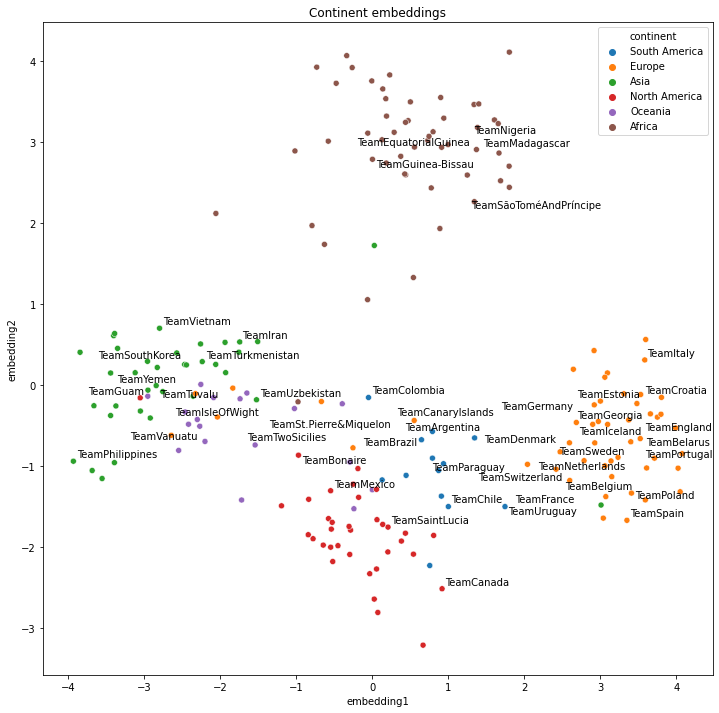

In [ ]:
plot_clusters("continent")

We can see above that the embeddings learned geographical similarities even though this information was not explicit on the original dataset.

Now we plot the same 2D embeddings but with the clusters found by K-Means:

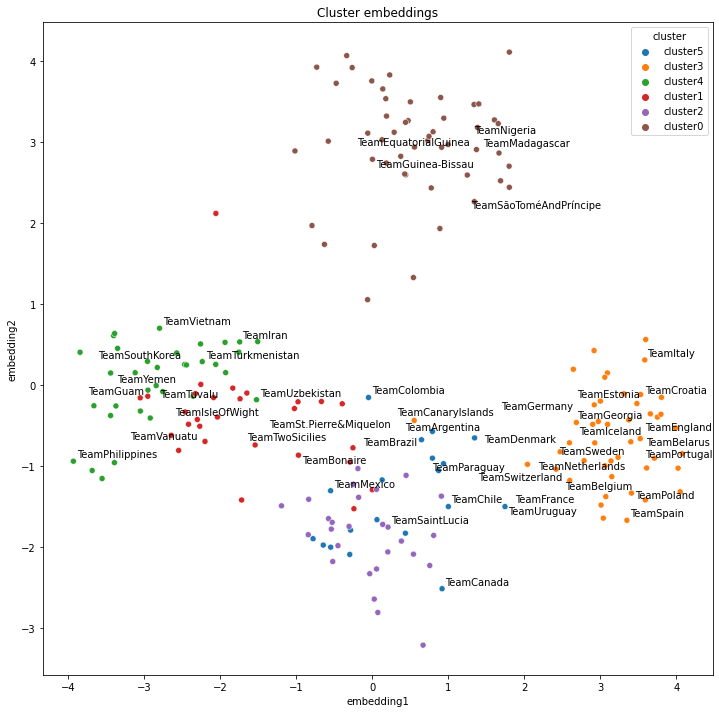

In [ ]:
plot_clusters("cluster")

We can see that K-Means found very similar cluster to the natural geographical clusters by the continents. This shows that on the 200-dimensional embedding space, similar teams appear close together, which can be captured by a clustering algorithm.

Our evaluation of the clusters can be more objective by using a metric such as the [adjusted Rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), which varies from -1 to 1, where 0 is random labelling and 1 is a perfect match:

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

0.4863586386624455

## Classification

We will use the knowledge embeddings to predict future matches as a classification problem.

We can model it as a multiclass problem with three classes: home team wins, home team loses, draw.

The embeddings are used directly as features to a XGBoost classifier.

First we need to determine the target:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sm.csv")
#df = df[df.price > 0]
print((df.price < 15000).astype(int))

0      1
1      1
2      1
3      1
4      1
      ..
382    1
383    1
384    1
385    1
386    1
Name: price, Length: 387, dtype: int64


In [ ]:
df["results"] = (df.price < 15000).astype(int) + \
                ((df.price >=15000)&(df.price < 30000)).astype(int)*2 + \
                (df.price >= 30000).astype(int)*3 - 1

In [ ]:
df.results.value_counts(normalize=True)

0    0.521964
1    0.242894
2    0.235142
Name: results, dtype: float64

### Original dataset

First install xgboost with `pip install xgboost`.

In [ ]:
!pip install xgboost

In [ ]:
new_df = df[["results", "Поддержка сетей 4G (LTE)", "Поддержка сетей 5G", "Поддержка быстрой зарядки", "Поддержка беспроводной зарядки", \
             "Степень защиты IP", "Стереодинамики"]].copy()
new_df

,results,Поддержка сетей 4G (LTE),Поддержка сетей 5G,Поддержка быстрой зарядки,Поддержка беспроводной зарядки,Степень защиты IP,Стереодинамики
0,0,False,False,False,False,False,False
1,0,False,False,False,False,False,False
2,0,False,False,False,False,False,False
3,0,False,False,False,False,False,False
4,0,False,False,False,False,False,False
...,...,...,...,...,...,...,...
382,0,True,False,True,False,True,True
383,0,True,True,True,False,True,True
384,0,True,False,False,False,False,False
385,0,True,False,False,False,False,False


Apply one hot encoding:

In [ ]:
encoded_cols = pd.get_dummies(df[["Страна-производитель", "name", "Год релиза", "Диагональ экрана (дюйм)", "Разрешение экрана", "Плотность пикселей",\
                                  "Технология изготовления экрана", "Частота обновления экрана", "Вес", "Бренд", "Аккумулятор"]])
encoded_cols

,Год релиза,Диагональ экрана (дюйм),Плотность пикселей,Частота обновления экрана,Вес,Аккумулятор,Страна-производитель_Вьетнам,Страна-производитель_Гонконг,Страна-производитель_Индия,Страна-производитель_Китай,...,Бренд_Samsung,Бренд_Sony,Бренд_TCL,Бренд_Tecno,Бренд_Tp-Link,Бренд_Vertex,Бренд_Vivo,Бренд_Wigor,Бренд_Xiaomi,Бренд_realme
0,2018,4.00,244.0,60,109.0,1000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2021,4.00,170.0,60,110.3,1440,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2020,5.00,196.0,60,152.0,2000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2020,5.00,214.0,60,NaN,2500,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2020,5.00,214.0,60,NaN,3000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2019,6.10,449.0,60,164.0,3140,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
383,2020,6.10,449.0,120,163.0,4000,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
384,2019,6.20,277.0,60,168.0,3400,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
385,2022,6.26,280.0,60,179.0,4000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
new_df = new_df.join(encoded_cols)
new_df

,results,Поддержка сетей 4G (LTE),Поддержка сетей 5G,Поддержка быстрой зарядки,Поддержка беспроводной зарядки,Степень защиты IP,Стереодинамики,Год релиза,Диагональ экрана (дюйм),Плотность пикселей,...,Бренд_Samsung,Бренд_Sony,Бренд_TCL,Бренд_Tecno,Бренд_Tp-Link,Бренд_Vertex,Бренд_Vivo,Бренд_Wigor,Бренд_Xiaomi,Бренд_realme
0,0,False,False,False,False,False,False,2018,4.00,244.0,...,0,0,0,0,0,0,0,0,0,0
1,0,False,False,False,False,False,False,2021,4.00,170.0,...,0,0,0,0,0,0,0,0,0,0
2,0,False,False,False,False,False,False,2020,5.00,196.0,...,0,0,0,0,0,0,0,0,0,0
3,0,False,False,False,False,False,False,2020,5.00,214.0,...,0,0,0,0,0,0,0,0,0,0
4,0,False,False,False,False,False,False,2020,5.00,214.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,0,True,False,True,False,True,True,2019,6.10,449.0,...,0,1,0,0,0,0,0,0,0,0
383,0,True,True,True,False,True,True,2020,6.10,449.0,...,0,1,0,0,0,0,0,0,0,0
384,0,True,False,False,False,False,False,2019,6.20,277.0,...,1,0,0,0,0,0,0,0,0,0
385,0,True,False,False,False,False,False,2022,6.26,280.0,...,0,0,0,0,0,0,0,0,0,0


Create a multiclass model:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
'''
X_train = new_df[df["Стереодинамики"]].drop(["results"], axis=1)
y_train = new_df[df["Стереодинамики"]].results
X_val = new_df[~df["Стереодинамики"]].drop(["results"], axis=1)
y_val = new_df[~df["Стереодинамики"]].results
'''
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(new_df.drop(["results"], axis=1), new_df.results, train_size=0.70, random_state=22)

df['Fit mask'] = y_train

def func(a):
  if a >= 0.0:
    return True
  
df['Fit mask'] = df['Fit mask'].apply(func)
df['Fit mask'].fillna(False, inplace=True)
print(df['Fit mask'].isna().sum())
df['Fit mask'].value_counts()

0


True     270
False    117
Name: Fit mask, dtype: int64

In [ ]:
clf_model.fit(X_train, y_train, verbose=1)

XGBClassifier(max_depth=5, n_estimators=500, objective='multi:softprob')

Result


In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.38461538461538464

### Graph embedings

Now we create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset:

In [ ]:
smartphones = df['name'][df['Fit mask']]
def uri(x):
  return x#+"http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#" + x
smartphones = smartphones.apply(uri)
print(smartphones)
smartphone_embeddings = dict(zip(smartphones, model.get_embeddings(smartphones)))

def get_features_target(mask):
    
    def get_embeddings(model):
        return smartphone_embeddings.get(model, np.full(200, np.nan))
    
    X = np.vstack(df[mask].name.apply(get_embeddings).values)
    y = df[mask].results.values
    return X, y

0              INOI_1_Lite
1                DEXP_A440
2                DEXP_G450
3            DEXP_A350_MIX
5               DEXP_AL250
              ...         
378    Apple_iPhone_13_Pro
379    Apple_iPhone_13_Pro
381     Samsung_Galaxy_A41
383       Sony_Xperia_5_II
386         Doogee_S88_Pro
Name: name, Length: 270, dtype: object


In [ ]:
clf_X_train, y_train = get_features_target((df['Fit mask']))
clf_X_test, y_test = get_features_target((~df['Fit mask']))

In [ ]:
clf_X_train.shape, clf_X_test.shape
#print(clf_X_train)

((270, 200), (117, 200))

Note that we have 200 features by team because the ComplEx model uses imaginary and real number for its embeddings, so we have twice as many parameters as defined by `k=100` in its model definition.

We also have some missing information from the embeddings of the entities (i.e. teams) that only appear in the test set, which are unlikely to be correctly classified:

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

115.0

Create a multiclass model with 500 estimators:

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Fit the model using all of the training samples:

In [ ]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(max_depth=5, n_estimators=500, objective='multi:softprob')

The baseline accuracy for this problem is 47%, as that is the frequency of the most frequent class (home team wins):

In [ ]:
df[~df['Fit mask']].results.value_counts(normalize=True)

0    0.504274
2    0.256410
1    0.239316
Name: results, dtype: float64

In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.5128205128205128

In conclusion, while the baseline for this classification problem was 47%, with just the knowledge embeddings alone we were able to build a classifier that achieves **54%** accuracy.

As future work, we could add more features to the model (not embeddings related) and tune the model hyper-parameters.

## Link prediction


Link prediction allows us to infer missing links in a graph. 

In our case, we're going to predict match result.
Choose match that exist in train dataset.

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=2000)

In [ ]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
modelSubject = "http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone#Poco_M3_Pro"
print(df[df.subject==modelSubject])

                                                 subject  \
230    http://www.semanticweb.org/eugene/ontologies/2...   
247    http://www.semanticweb.org/eugene/ontologies/2...   
269    http://www.semanticweb.org/eugene/ontologies/2...   
842    http://www.semanticweb.org/eugene/ontologies/2...   
1401   http://www.semanticweb.org/eugene/ontologies/2...   
1832   http://www.semanticweb.org/eugene/ontologies/2...   
2501   http://www.semanticweb.org/eugene/ontologies/2...   
2917   http://www.semanticweb.org/eugene/ontologies/2...   
3050   http://www.semanticweb.org/eugene/ontologies/2...   
3111   http://www.semanticweb.org/eugene/ontologies/2...   
3226   http://www.semanticweb.org/eugene/ontologies/2...   
3709   http://www.semanticweb.org/eugene/ontologies/2...   
4017   http://www.semanticweb.org/eugene/ontologies/2...   
4492   http://www.semanticweb.org/eugene/ontologies/2...   
5694   http://www.semanticweb.org/eugene/ontologies/2...   
6446   http://www.semanticweb.org/eugene

Remove result for this model from train dataframe.

In [ ]:
dfFiltered = (df[(df.subject!=modelSubject) | ((df.subject==modelSubject) & ~df.predicate.isin(["http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price"]))])
print(dfFiltered[dfFiltered.subject==modelSubject])
dfFiltered = np.array(df)
print(dfFiltered.shape)

                                                 subject  \
230    http://www.semanticweb.org/eugene/ontologies/2...   
247    http://www.semanticweb.org/eugene/ontologies/2...   
269    http://www.semanticweb.org/eugene/ontologies/2...   
842    http://www.semanticweb.org/eugene/ontologies/2...   
1401   http://www.semanticweb.org/eugene/ontologies/2...   
1832   http://www.semanticweb.org/eugene/ontologies/2...   
2501   http://www.semanticweb.org/eugene/ontologies/2...   
2917   http://www.semanticweb.org/eugene/ontologies/2...   
3050   http://www.semanticweb.org/eugene/ontologies/2...   
3111   http://www.semanticweb.org/eugene/ontologies/2...   
3226   http://www.semanticweb.org/eugene/ontologies/2...   
3709   http://www.semanticweb.org/eugene/ontologies/2...   
4017   http://www.semanticweb.org/eugene/ontologies/2...   
4492   http://www.semanticweb.org/eugene/ontologies/2...   
5694   http://www.semanticweb.org/eugene/ontologies/2...   
6446   http://www.semanticweb.org/eugene

Fit model on triples without results for current match.

In [ ]:
model.fit(dfFiltered)

Average ComplEx Loss:   0.178428: 100%|██████████| 300/300 [01:51<00:00,  2.70epoch/s]


We can create a few statements for this match result.

In [ ]:
statements = np.array([
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '10999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '15999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '17999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '19999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '20999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '21999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '23999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '26999'],
    [f'{modelSubject}', 'http://www.semanticweb.org/eugene/ontologies/2022/1/smartphone-1#price', '32999']
])

Unite the triplets of the graph and the proposed statements.

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
len(statements_filter)
statements_filter.shape

(18087, 3)

In [ ]:
ranks_statements = evaluate_performance(
    statements, 
    model=model, 
    filter_triples=statements_filter, 
    corrupt_side = 's+o',
    use_default_protocol=False,
    verbose=True)

100%|██████████| 9/9 [00:00<00:00, 58.89it/s]


In [ ]:
scores = model.predict(statements)
scores

array([4.682702 , 4.434669 , 8.23976  , 7.9770427, 7.5786767, 8.941796 ,
       8.097279 , 6.2942896, 4.4572477], dtype=float32)

Present the result of predictions.

In [ ]:
from scipy.special import expit
probs = expit(scores)

sorted = pd.DataFrame(list(zip([' '.join(x) for x in statements], 
                      ranks_statements, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob", ascending=False)

sorted['price'] = sorted['statement'].apply(lambda row: int(row.split(' ')[-1]))
result = sorted[['price', 'prob']].set_index('price')
result

,prob
price,
21999,0.999869
17999,0.999736
23999,0.999696
19999,0.999657
20999,0.999489
26999,0.998157
10999,0.990831
32999,0.988539
15999,0.988280


In [ ]:
print("10")

10
